###### 0. Loading libraries

In [1]:
%matplotlib notebook
import requests
import os
import sys
from boto.s3.connection import S3Connection
from boto.s3.key import Key
from string import punctuation
import pandas as pd
import numpy as np
import re
from IPython.display import Image
from IPython.core.display import HTML

###### 1. Setting global variables

In [2]:
CRAWLER_SWITCH = False
S3_IO = False
ACCESS_KEY = ""
SECRET_KEY = ""
BUCKET_NAME = 'parks101'
READ_SWITCH = False
WRITE_SWITCH = False
#FIT_SWITCH = True
DATA_FOLDER = '/Users/Wei.Zhao/Documents/Python code/tripadvisor/'
MODEL_FOLDER = '/Users/Wei.Zhao/Documents/Python code/tripadvisor/models/'
PARK_INFO_FILE = 'parks_info.csv'
REVIEW_RAW_FILE = 'reviews_raw.csv'

In [3]:
print DATA_FOLDER

/Users/Wei.Zhao/Documents/Python code/tripadvisor/


###### 2. Crawler for TripAdvisor

In [4]:
if CRAWLER_SWITCH:
    session = requests.Session()
    main_url='https://www.tripadvisor.com/search'
    mainparam={'geo':191,
               'q':'national park',
               'ssrc':'A',
               'pid':3826,
               'searchSessionId':'46549A5CD2DA12896A781F89A234F6231474940074956ssid',
               'o': 60}
    headers = {'User-Agent': 'Mozilla/5.0 (iPad; U; CPU OS 3_2_1 like Mac OS X; en-us) AppleWebKit/531.21.10 (KHTML, like Gecko) Mobile/7B405'}
    main_page = session.get(main_url, params=mainparam,headers=headers)

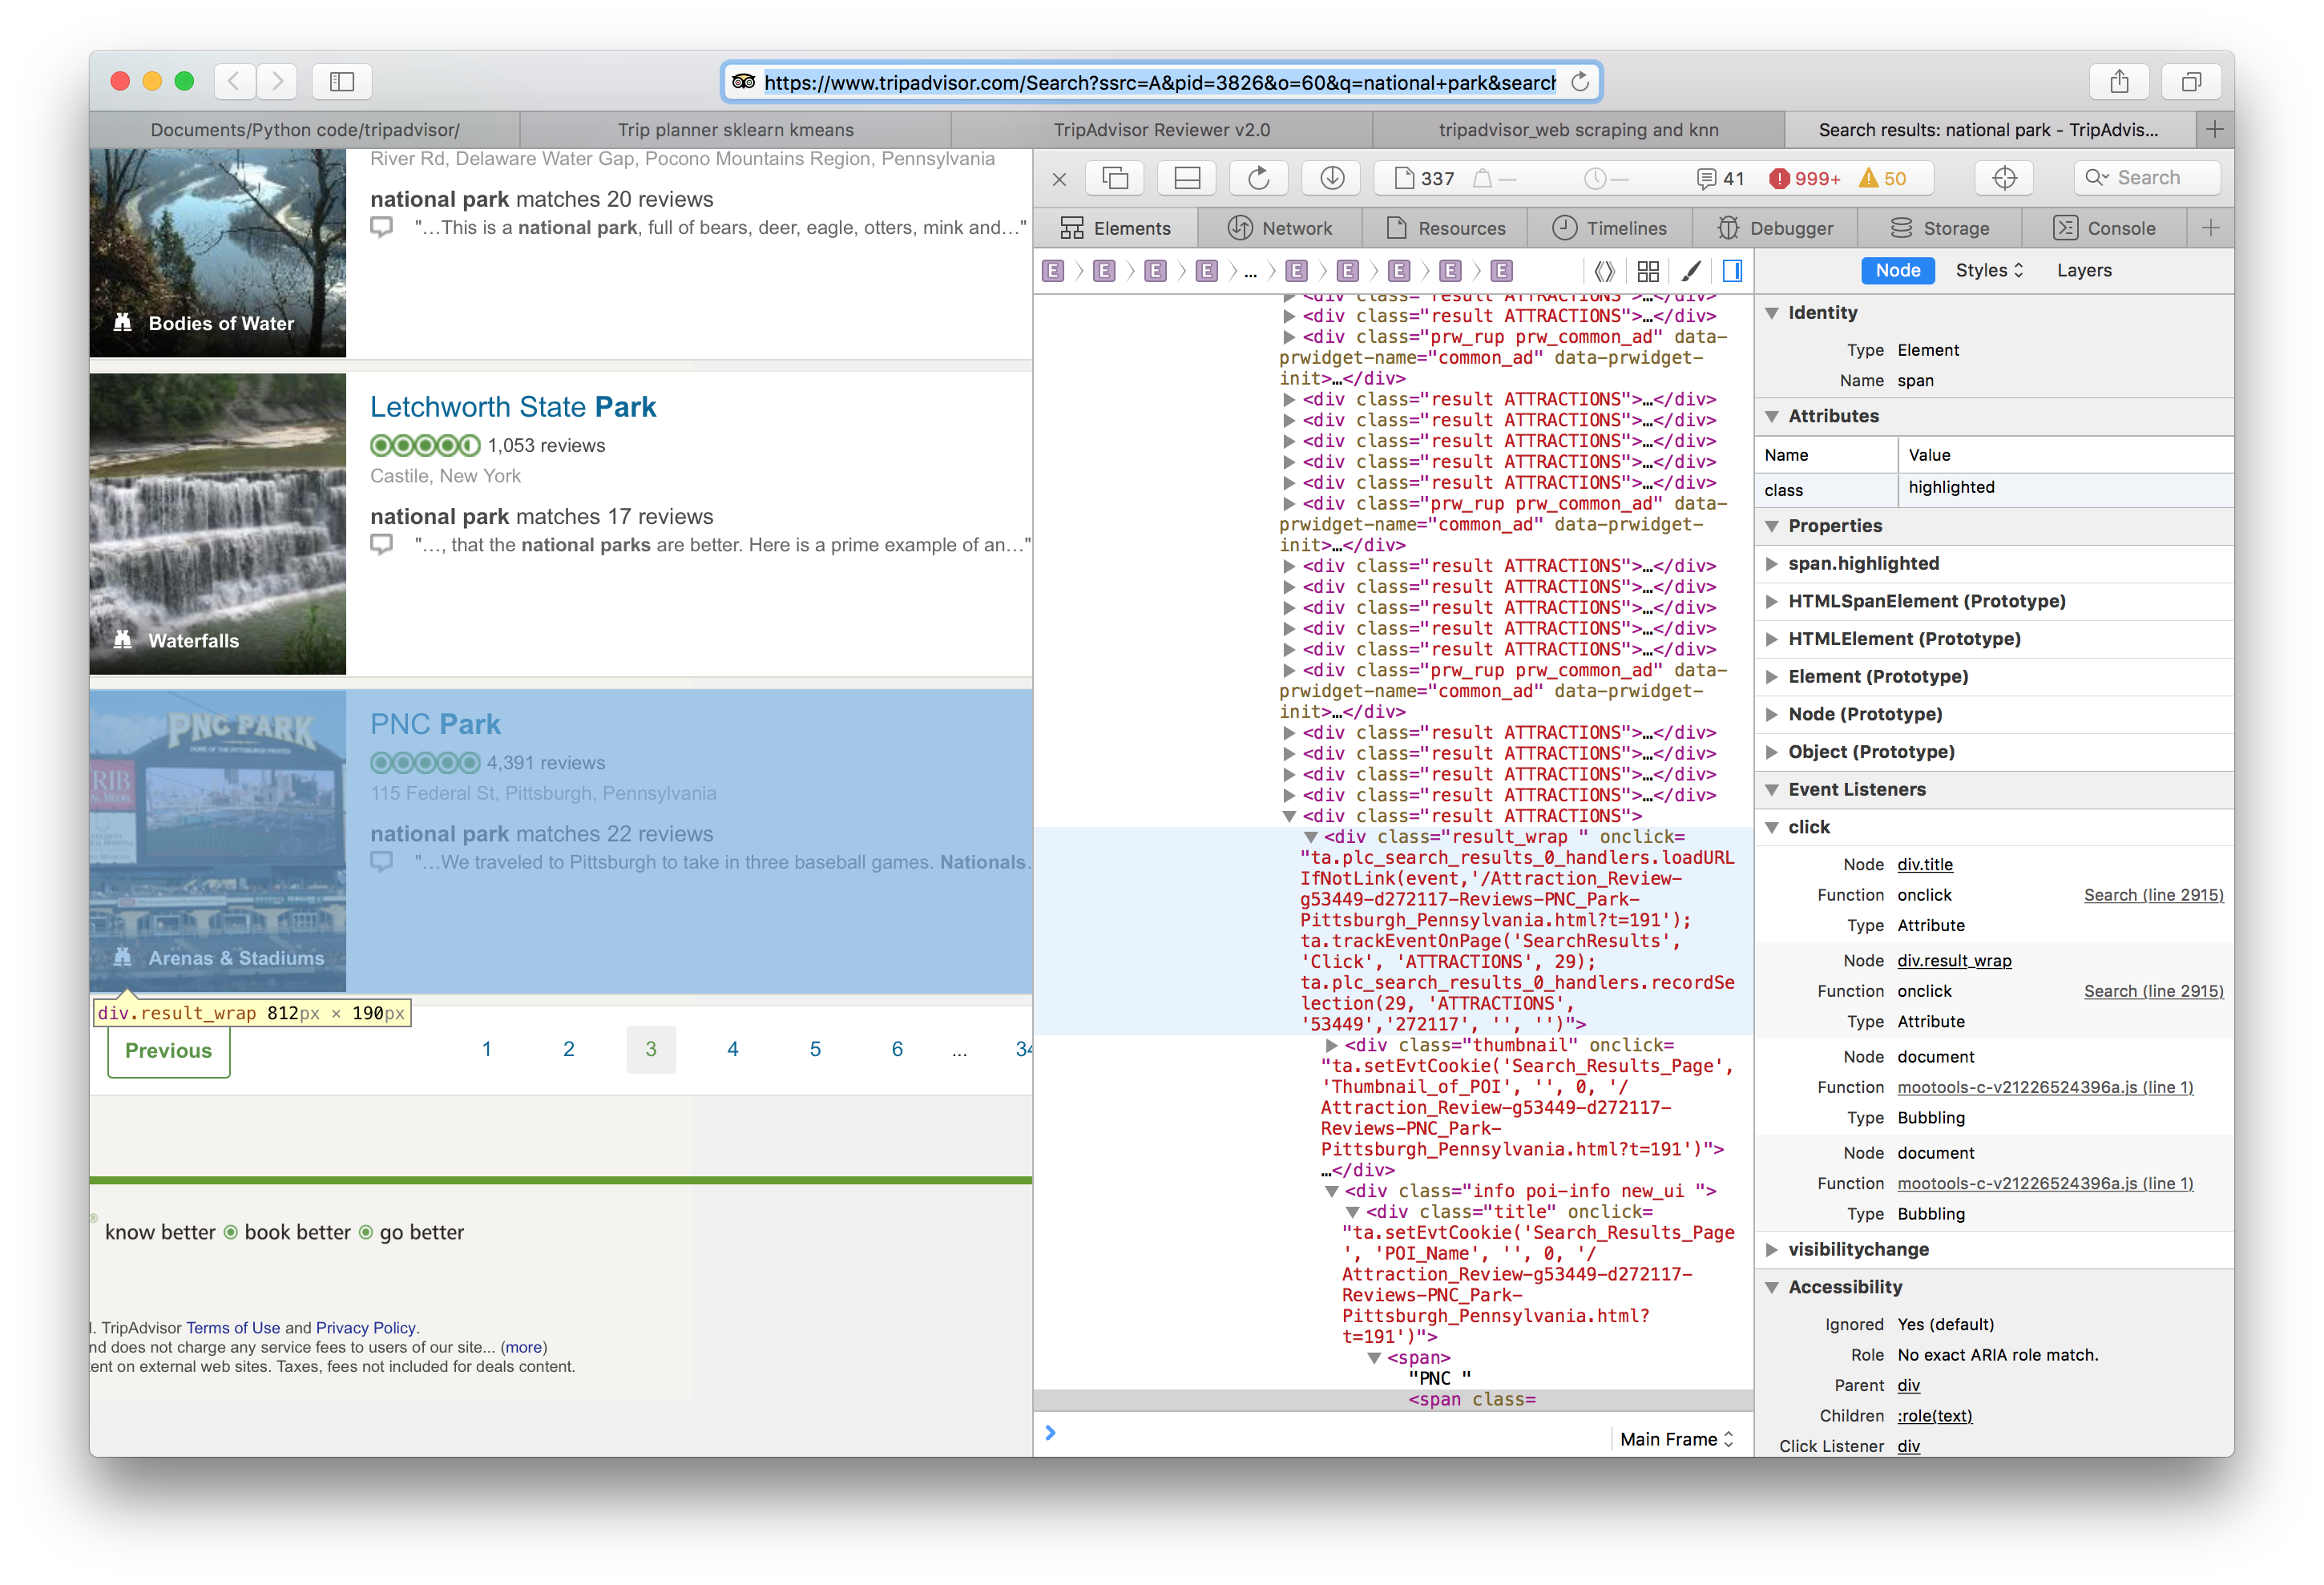

In [20]:
Screenshot_1 = 'ScreenShot 1.PNG'
Image(os.path.join(DATA_FOLDER, Screenshot_1))

In [6]:
if CRAWLER_SWITCH:
    pattern='(Attraction_Review[a-zA-Z0-9_-]+\.html)\?t=191#REVIEWS'
    main_url='https://www.tripadvisor.com/search'
    linkcollect=[]
    t = 0
    xlink_old=[]
    while True:   
        o = t*30+0 # each page there are 30 parks listed
        mainparam={'geo':191,
                   'q':'national park',
                   'ssrc':'A',
                   'pid': '3826',
                   'searchSessionId':'2C2F96275978EA98949D5C5A74AE6F101474939141442',
                   'o': o
                   }
        t=t+1
        main_page = session.get(main_url, params=mainparam) 


        xlink = re.findall(pattern, main_page.content)
        #print xlink
        if t%10==0:
            print xlink[1]
        if xlink and xlink[1]!= xlink_old:
            for i in xlink:
                linkcollect.append('https://www.tripadvisor.com/'+i)
        else:
            break
        xlink_old=xlink[1]                     

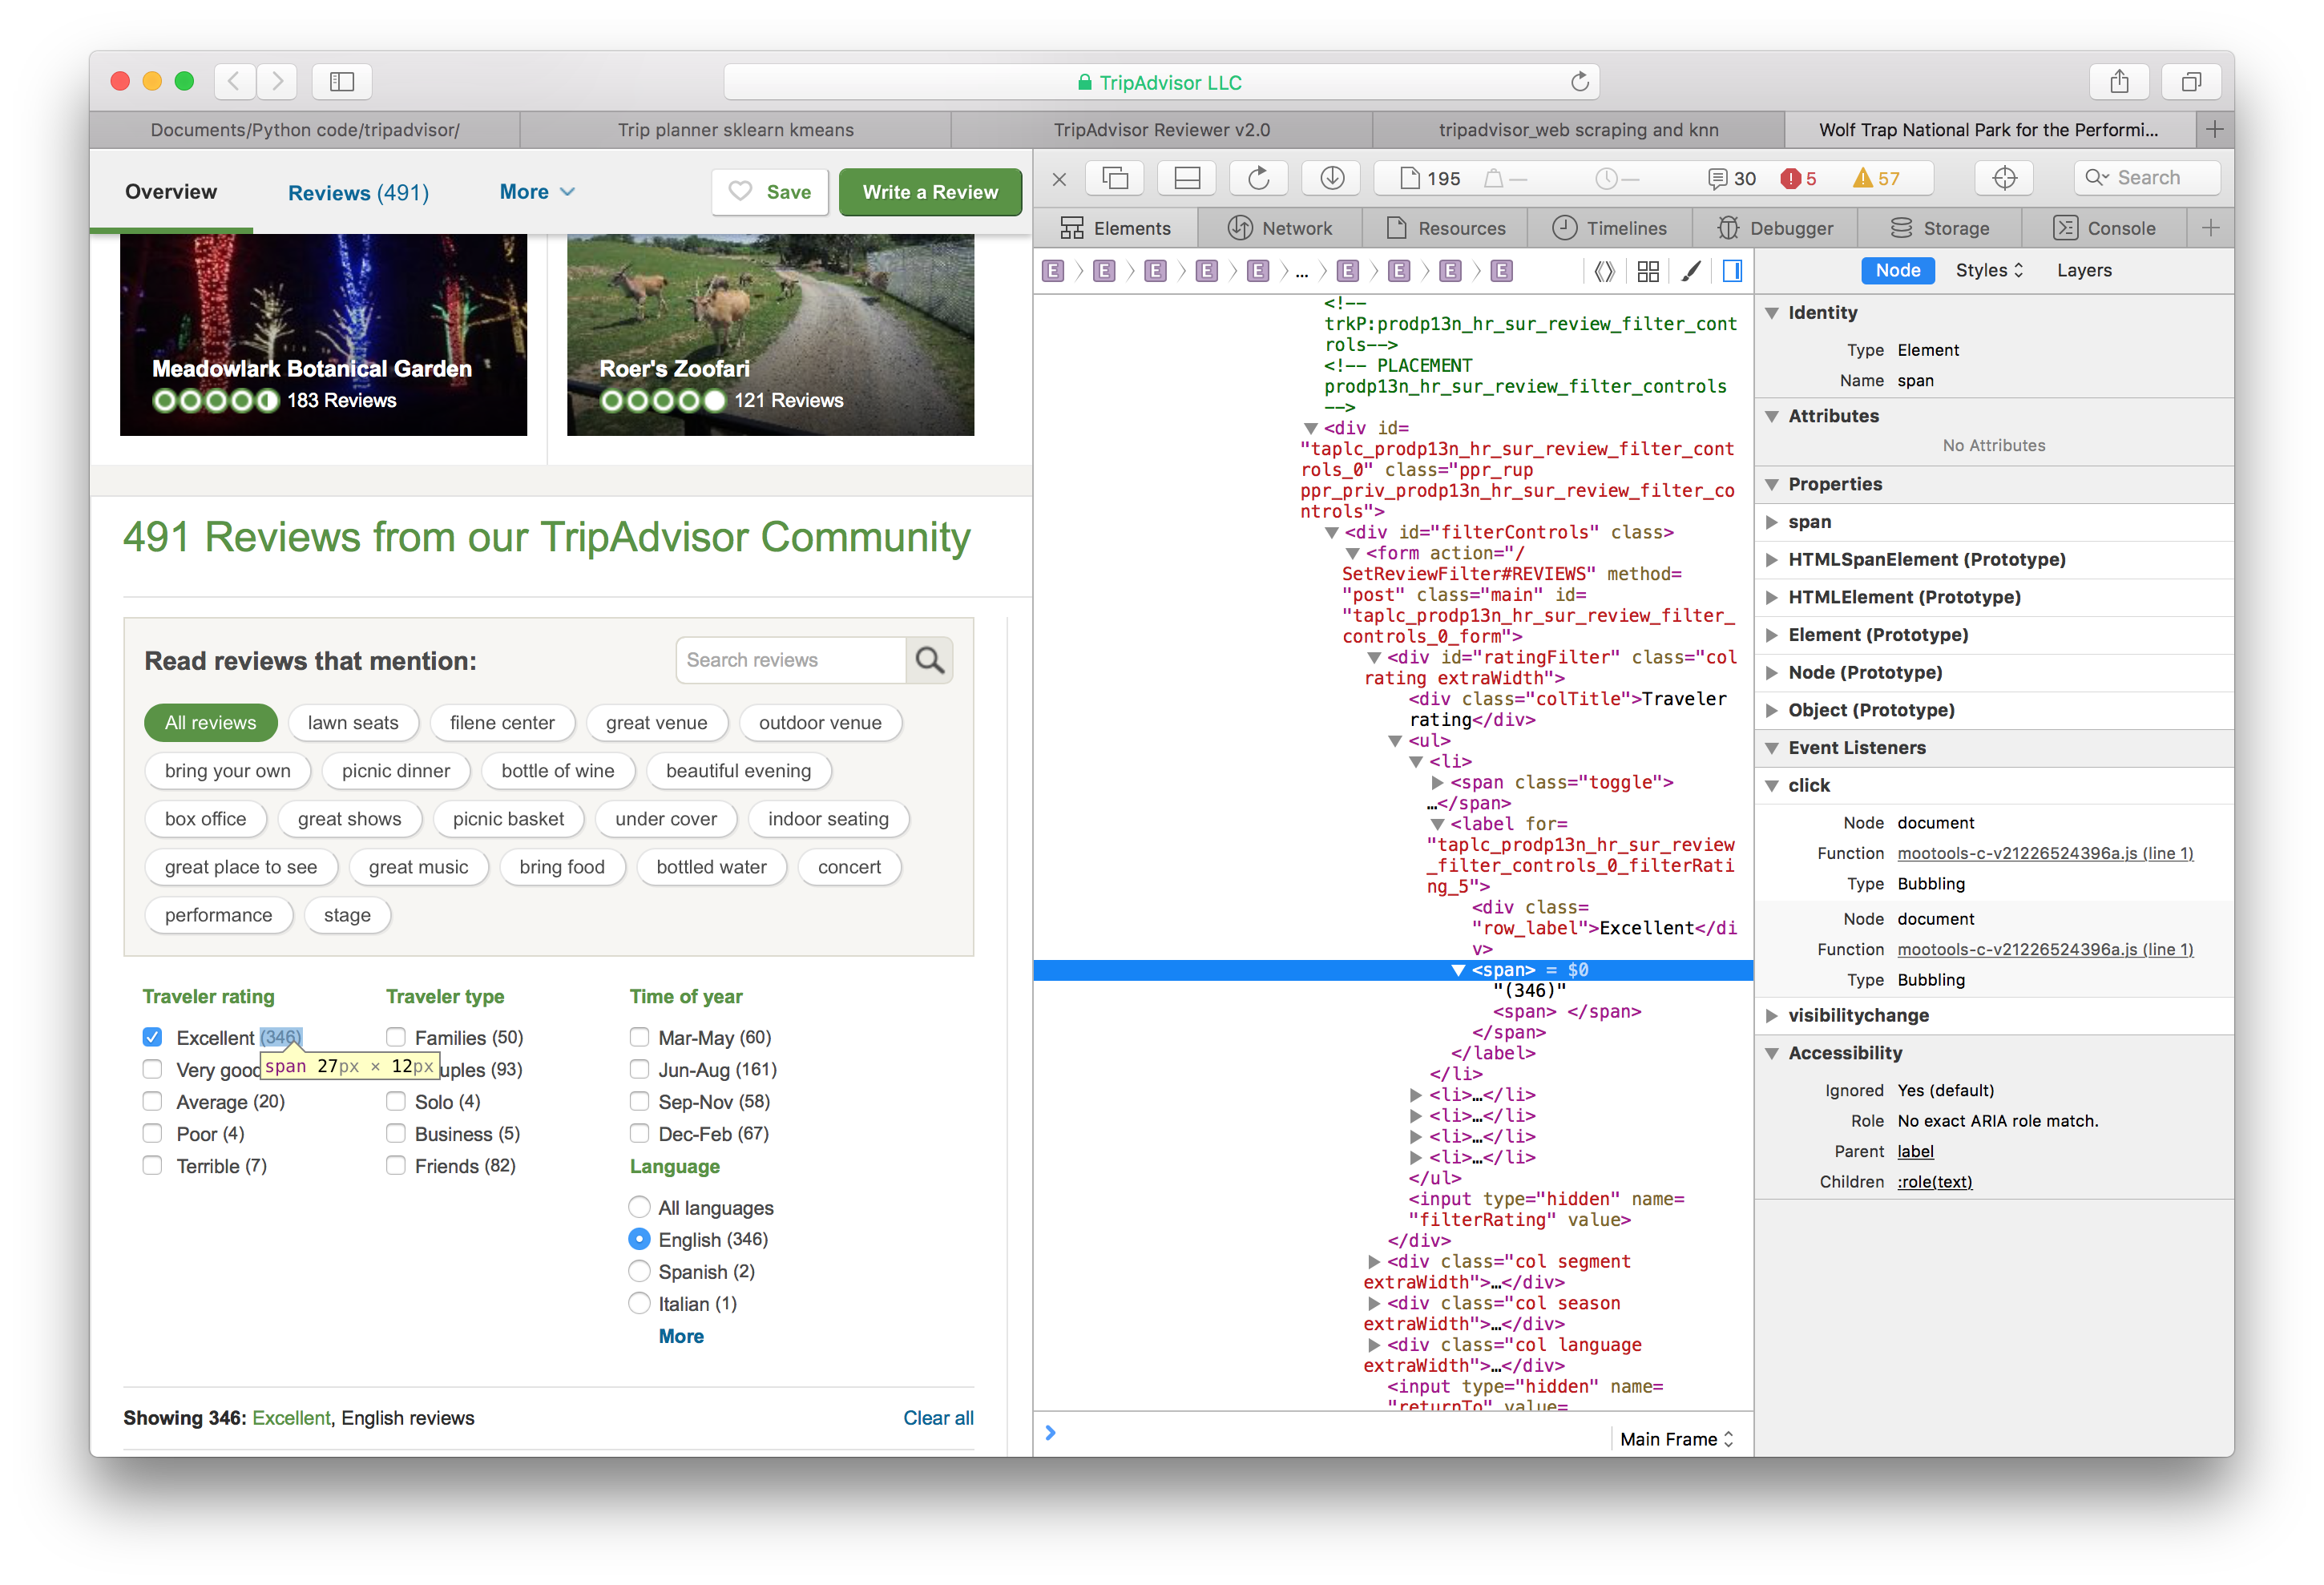

In [21]:
Screenshot_2 = 'ScreenShot 2.PNG'
Image(os.path.join(DATA_FOLDER, Screenshot_2))

In [8]:
if CRAWLER_SWITCH:
    pt2=r'-Reviews-([a-zA-Z0-9_]+)-([a-zA-Z0-9_]+)_([a-zA-Z]+)\.html'
    parks = pd.DataFrame(columns=['park_id','html','name','city','state','Excellent','Very_good',
                                 'Average','Poor','Terrible','Families','Couples','Friends','Solo',
                                 'Business','Spring','Summer','Fall','Winter'])
    park_id = int(0)
    for link in linkcollect: 
        link_content=session.get(link).content
        try:
            x = re.search(pt2,link) 
            parks = parks.append({
                          'park_id':park_id,
                          'html':link,
                          'name':x.group(1),
                          'city':x.group(2),
                          'state':x.group(3),
                          'Excellent': re.search('Excellent</div><span>\(([0-9,]+)\)',link_content.replace('\n','')).group(1),
                          'Very_good':re.search('Very good</div><span>\(([0-9,]+)\)',link_content.replace('\n','')).group(1),
                          'Average': re.search('Average</div><span>\(([0-9,]+)\)',link_content.replace('\n','')).group(1),
                          'Poor': re.search('Poor</div><span>\(([0-9,]+)\)',link_content.replace('\n','')).group(1),
                          'Terrible': re.search('Terrible</div><span>\(([0-9,]+)\)',link_content.replace('\n','')).group(1),
                          'Families': re.search('Families <span>\(([0-9,]+)\)</span>', link_content.replace('\n','')).group(1),
                          'Couples': re.search('Couples <span>\(([0-9,]+)\)</span>', link_content.replace('\n','')).group(1),
                          'Friends': re.search('Friends <span>\(([0-9,]+)\)</span>', link_content.replace('\n','')).group(1),
                          'Solo': re.search('Solo <span>\(([0-9,]+)\)</span>', link_content.replace('\n','')).group(1),
                          'Business':re.search('Business <span>\(([0-9,]+)\)</span>', link_content.replace('\n','')).group(1),
                          'Spring':re.search('Mar-May <span>\(([0-9,]+)\)</span>', link_content.replace('\n','')).group(1),
                          'Summer': re.search('Jun-Aug <span>\(([0-9,]+)\)</span>', link_content.replace('\n','')).group(1),
                          'Fall': re.search('Sep-Nov <span>\(([0-9,]+)\)</span>', link_content.replace('\n','')).group(1),
                          'Winter':re.search('Dec-Feb <span>\(([0-9,]+)\)</span>', link_content.replace('\n','')).group(1)
                          }, ignore_index=True)
        except AttributeError:
            parks = parks.append({'park_id':park_id,
                          'html':link,
                          'name':None,
                          'city':None,
                          'state':None,
                          'Excellent': None,
                          'Very_good':None,
                          'Average': None,
                          'Poor': None,
                          'Terrible': None,
                          'Families': None,
                          'Couples': None,
                          'Friends': None,
                          'Solo': None,
                          'Business':None,
                          'Spring':None,
                          'Summer': None,
                          'Fall': None,
                          'Winter':None}, ignore_index=True)
        if park_id % 100 == 0:
            print park_id
        park_id = park_id + 1

In [9]:
if CRAWLER_SWITCH:
    info_file = os.path.join(DATA_FOLDER, PARK_INFO_FILE)
    if WRITE_SWITCH:
        parks.to_csv(info_file, header=True)

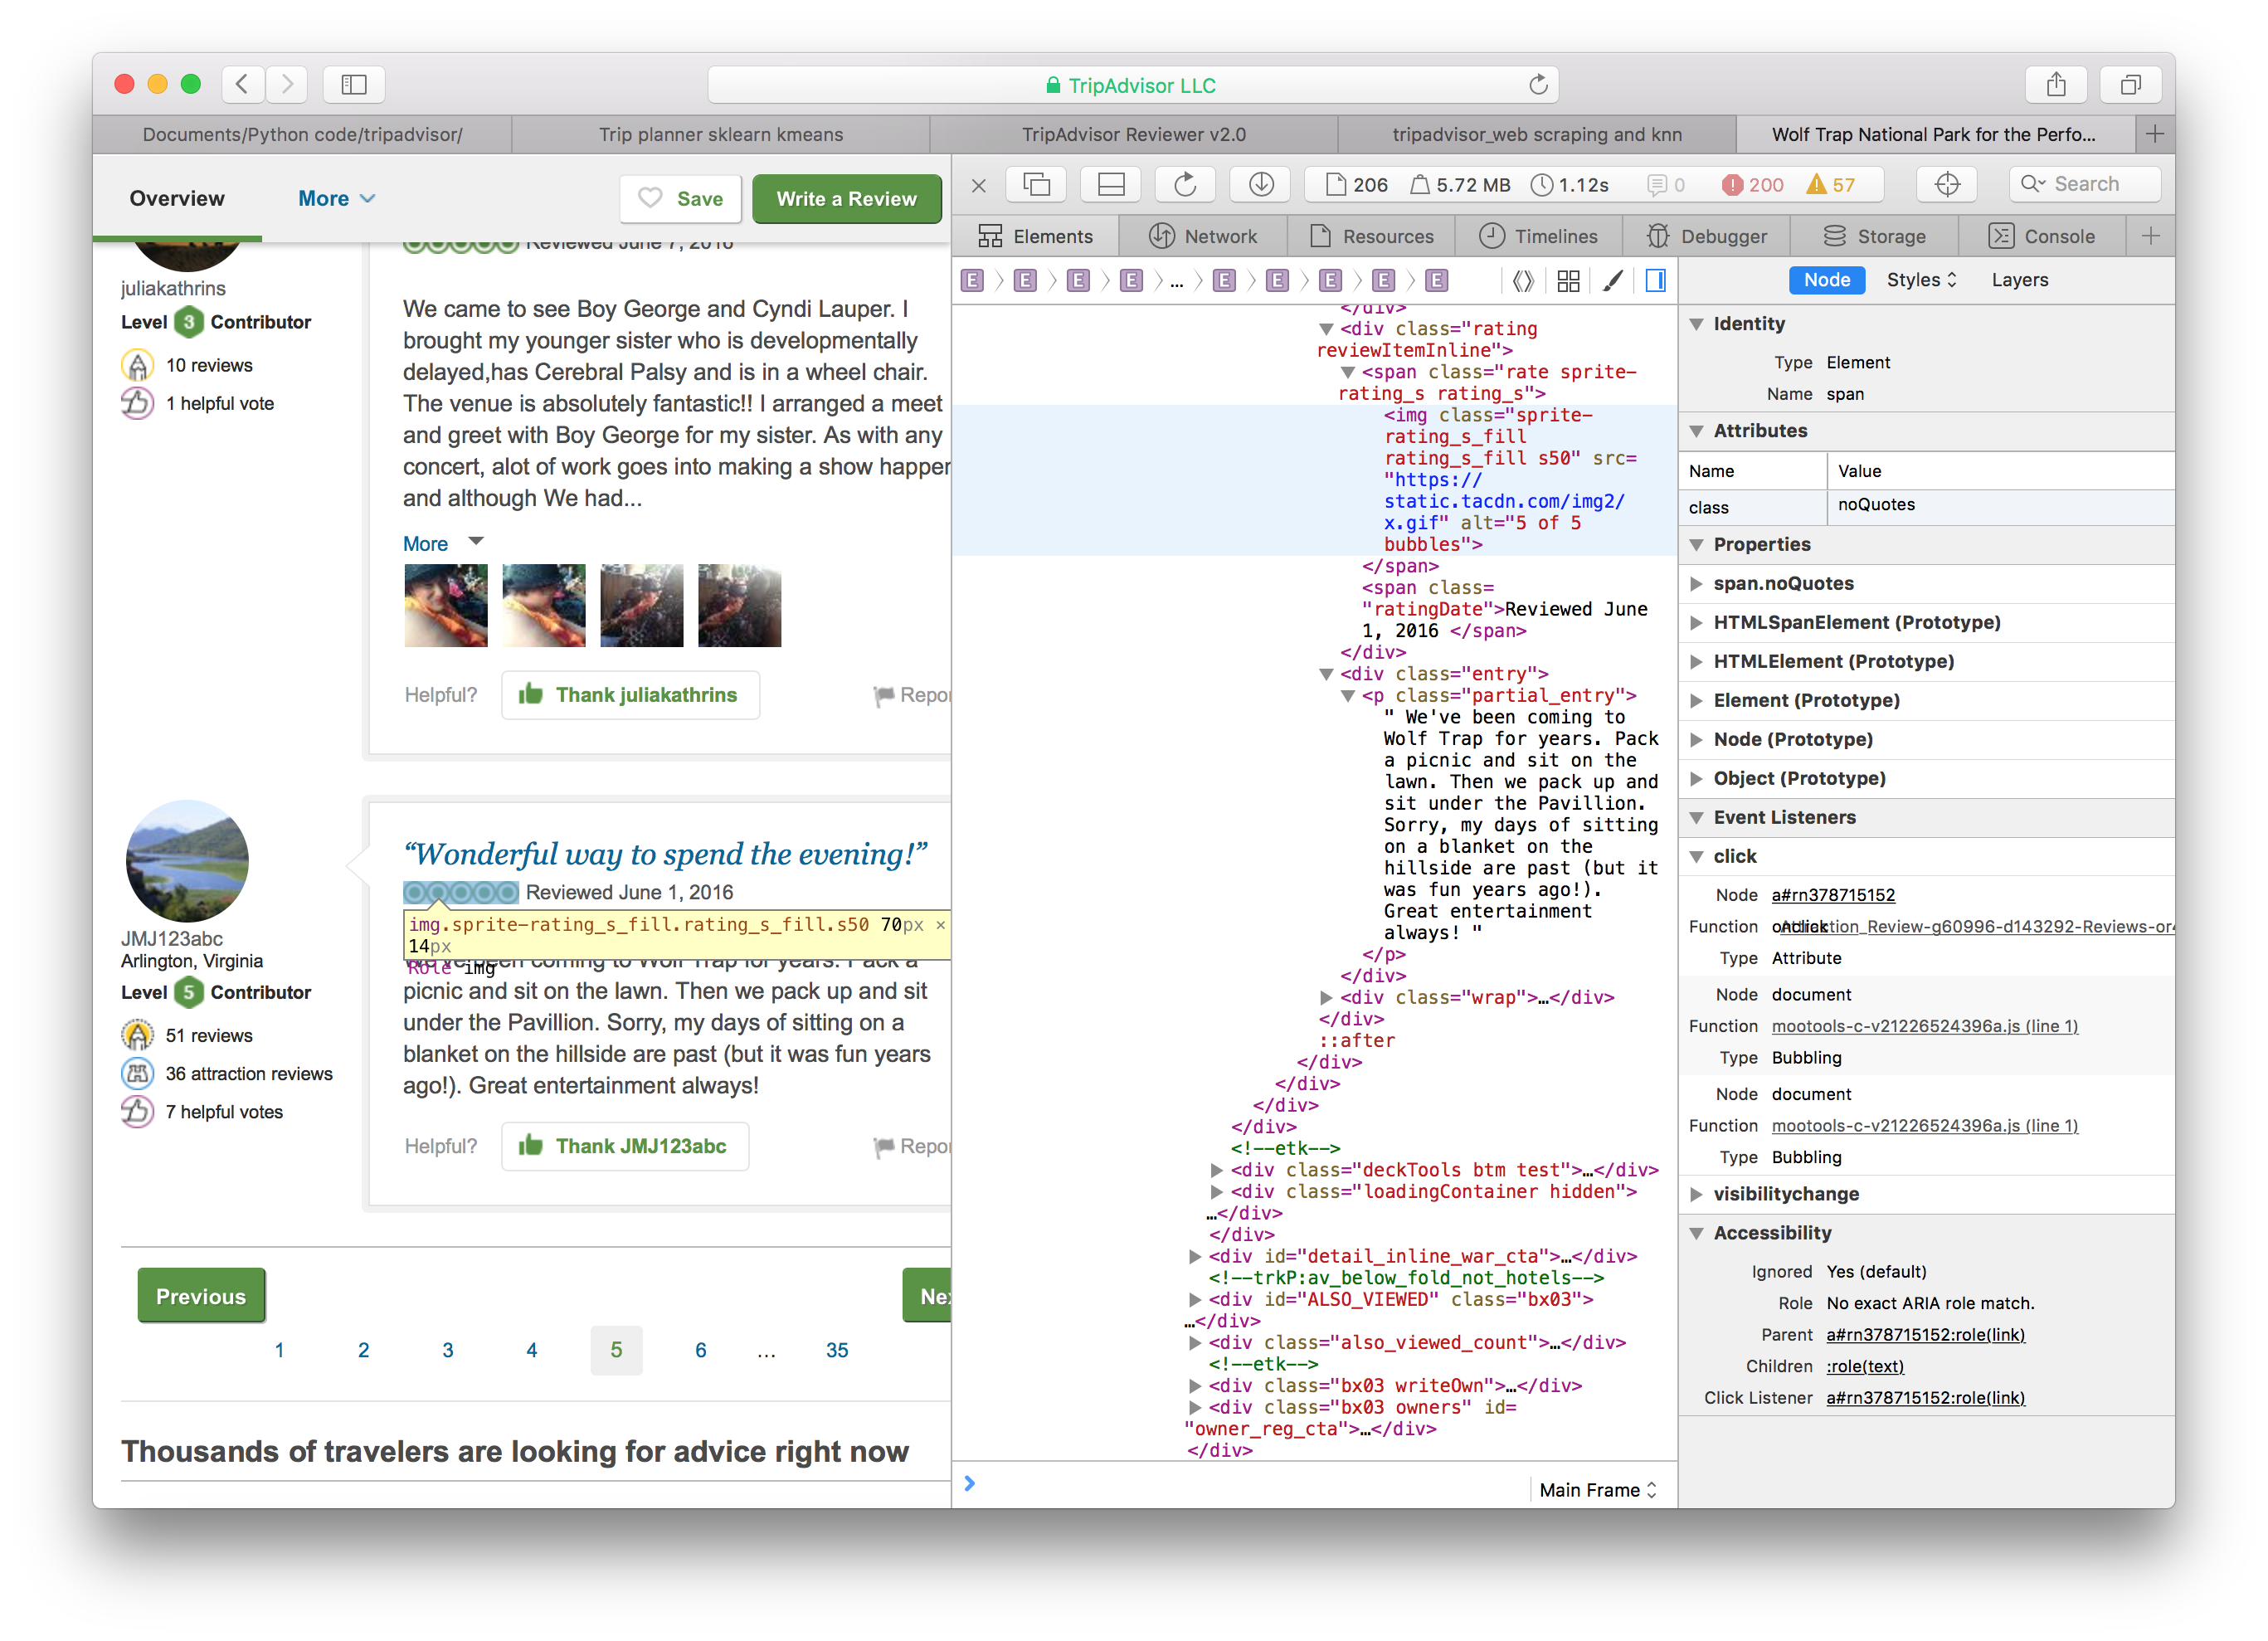

In [22]:
Screenshot_3 = 'ScreenShot 3.PNG'
Image(os.path.join(DATA_FOLDER, Screenshot_3))

In [11]:
def parse_review(park_id, onereview):
    try:
        user_name = re.search('user_name_name_click\'\)\"> ?(.*?) ?</span>',onereview).group(1)
    except AttributeError:
        user_name = 'unknown'
    try:
        user_level = float(re.search('<div class=\"levelBadge badge lvl_(\d+)\">',onereview).group(1))
    except AttributeError:
        user_level = 0.0
    try:
        title = re.search('<span class=\'noQuotes\'>(.*?)</span>',onereview).group(1)
    except AttributeError:
        title = 'unknown'
    try:
        stars = float(re.search('alt=\"(\d) of 5 \w+?\">',onereview).group(1))
    except AttributeError:
        stars = -1
    try:       
        r_date = re.search('\"ratingDate relativeDate\" title=\'(.*)\'>',onereview).group(1)
    except AttributeError:
        r_date = re.search(r'ratingDate\">Reviewed (.*?)</span>', onereview).group(1)
    try:
        comments = re.search('<p class=\"partial_entry\">(.*?)<span class=\"partnerRvw\">', onereview).group(1)
    except AttributeError:
        comments = re.search('<p class=\"partial_entry\">(.*?)</p>',onereview).group(1)
    
    onereview_info ={'park_id':park_id,
                     'user_name': user_name,
                     'user_level': user_level,
                     'title': title,
                     'star':stars,
                     'date':r_date,
                     'comments':comments
                     }
    return onereview_info

In [12]:
if CRAWLER_SWITCH:
    review_file = os.path.join(DATA_FOLDER, REVIEW_RAW_FILE) 
    parkreviews = pd.DataFrame(columns=['park_id','user_name','user_level','title','star','date','comments'])
    parks_n = len(parks)
    for i in range(parks_n):
        parkreviews = pd.DataFrame()
        park_review_link = parks.iloc[i]['html']
        park_id = parks.iloc[i]['park_id']
        print park_id,park_review_link
        first_page = session.get(park_review_link)
        try:
            page_num = int(re.search('\'STANDARD_PAGINATION\', \'last\', \'(\d+)\'',first_page.content.replace('\n','')).group(1))
        except AttributeError:
            page_num = 1
        revewlinkpartspattern = '(https://www\.tripadvisor\.com/Attraction_Review-[a-zA-Z0-9-]+Reviews)([a-zA-Z0-9_-]+\.html)'
        reviewlinkparts = re.search(revewlinkpartspattern,park_review_link)
        o=0
        for k in range(page_num):
            o1 = 10 * k + o 
            park_review_link = ''.join([reviewlinkparts.group(1), '-or', str(o1), reviewlinkparts.group(2)])
            #print park_review_link
            park_review_link_content = session.get(park_review_link).content
            reviews = re.findall(r'<!--trkN:\d*/R:\d*-->(.*?)<!--etk-->', park_review_link_content.replace('\n',''))
            for one_review in reviews:               
                parkreviews = parkreviews.append(parse_review(park_id, one_review),ignore_index=True)
        parkreviews.to_csv(review_file,mode ='a',header=False) 

In [16]:
if S3_IO and WRITE_SWITCH:
    s3_handle = S3Connection(ACCESS_KEY, SECRET_KEY)
    bucket_handle = s3_handle.get_bucket(BUCKET_NAME)
    for onefile, df in zip((PARK_INFO_FILE, REVIEW_RAW_FILE), (parks, parkreviews)):
        if onefile in [i.name for i in bucket_handle.list()]:
            file_exist = Key(bucket_handle)
            file_exist.key = onefile
            bucket_handle.delete_key(file_exist)
        new_file_handle = bucket_handle.new_key(onefile)
        new_file_handle.set_contents_from_string(df.to_csv())